# Behavioral Cloning

Part of the [Udacity self-driving car nanodegree](udacity.com/drive)

## Data Preprocessing

We want to get an idea of what our dataset looks like, the main hurdles for the data preprocessing part are:
 - splitting the left and right images and giving them an appropriate angle
 - taking care of the zero degree steering angle bias

In [2]:
import random
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Dense, Flatten, Dropout, Lambda, Reshape
from keras.layers.pooling import MaxPooling2D
from keras.layers.convolutional import Cropping2D, Conv2D

Using TensorFlow backend.


In [3]:
STEER_CORRECTION_FACTOR = 0.21
DATASET_CSV = "data/driving_log.csv"

VALIDATION_SPLIT = 0.05
DROPOUT_RATE = 0.15
LEARNING_RATE = 0.001
N_EPOCHS = 10
BATCH_SIZE = 256

def get_filename(path, top_path="data/IMG/", folder_divider="/"):
    """
    Get file name from its path
    """
    return top_path + path.split(folder_divider)[-1]

Number of datapoints:  8036
Number of datapoints at zero degree steering angle:  4361
Percent of steering angle datapoints equal to zero: 54.3%


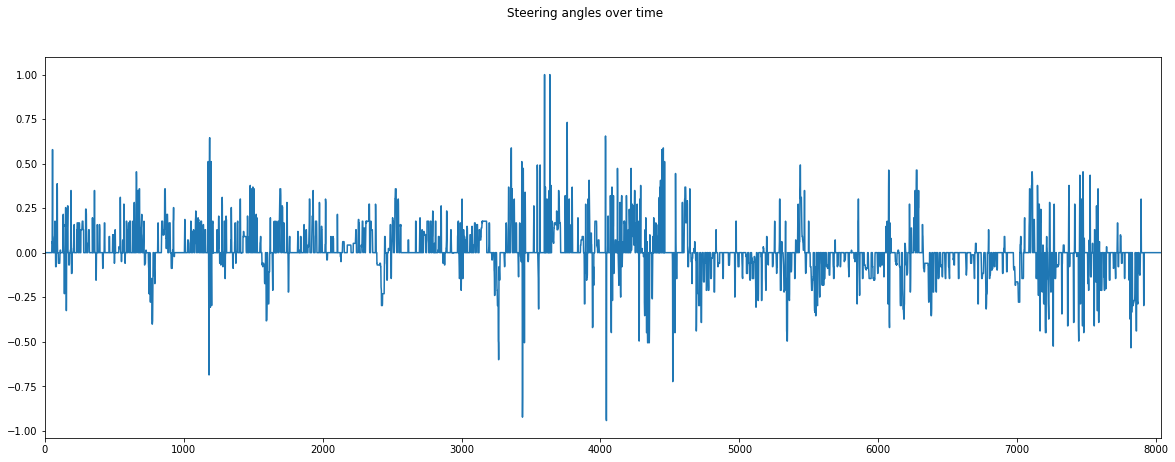

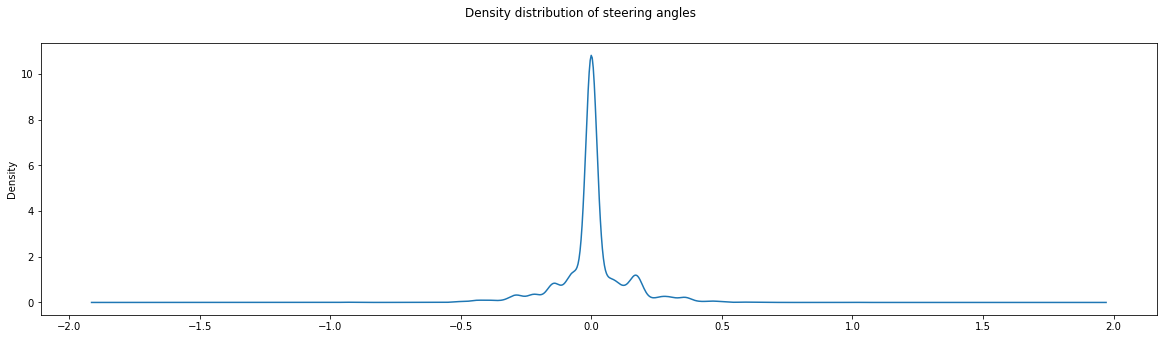

In [4]:
# df is our dataset dataframe, calling it like that to make shorter more readable conditional filtering later on
df = pd.read_csv(DATASET_CSV,
                converters={0: get_filename, 1: get_filename, 2: get_filename},
                names=["center_img", "left_img", "right_img", "steering", "something", "something_2", "throttle"])

# Delete everything we dont need
df.drop('something', axis=1, inplace=True)
df.drop('something_2', axis=1, inplace=True)
df.drop('throttle', axis=1, inplace=True)

def get_dataframe_steering_info(dataframe, steering_col="steering"):
    
    print("Number of datapoints: ", len(dataframe))

    n_steering_angles_at_zero = len(dataframe[dataframe[steering_col] == 0])
    n_steering_angles_at_nonzero = len(dataframe) - n_steering_angles_at_zero
    percent_steering_angles_at_zero = n_steering_angles_at_zero / len(dataframe)
    
    print("Number of datapoints at zero degree steering angle: ", n_steering_angles_at_zero)
    print("Percent of steering angle datapoints equal to zero: {:.1f}%".format(percent_steering_angles_at_zero * 100))
    
    plt.figure(figsize=(20, 7)).suptitle("Steering angles over time")
    dataframe[steering_col].plot()
    
    plt.figure(figsize=(20, 5)).suptitle("Density distribution of steering angles")
    dataframe[steering_col].plot(kind='kde')
    plt.show()
    
    return (n_steering_angles_at_zero, n_steering_angles_at_nonzero)

n_steering_angles_at_zero, n_steering_angles_at_nonzero = get_dataframe_steering_info(df)
%matplotlib inline

Number of datapoints:  4111
Number of datapoints at zero degree steering angle:  436
Percent of steering angle datapoints equal to zero: 10.6%


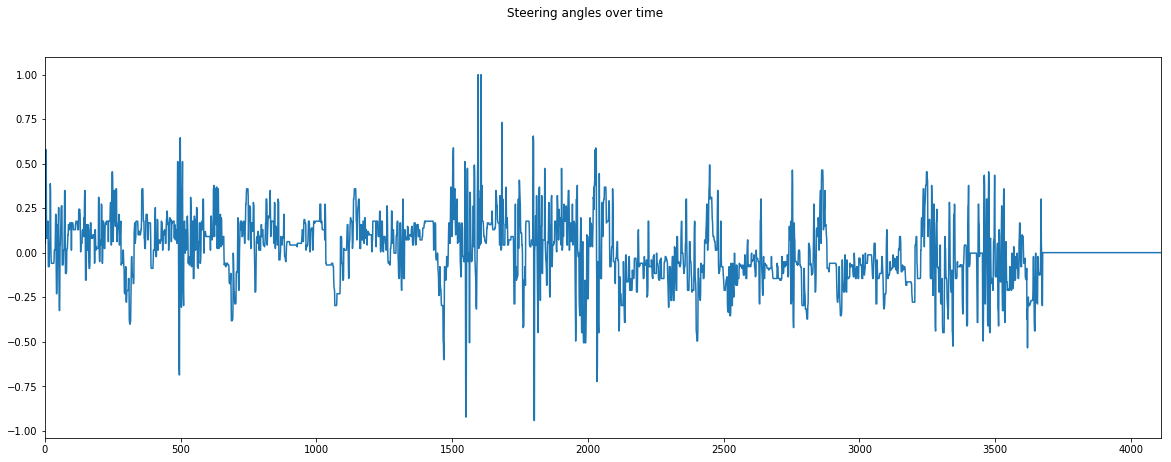

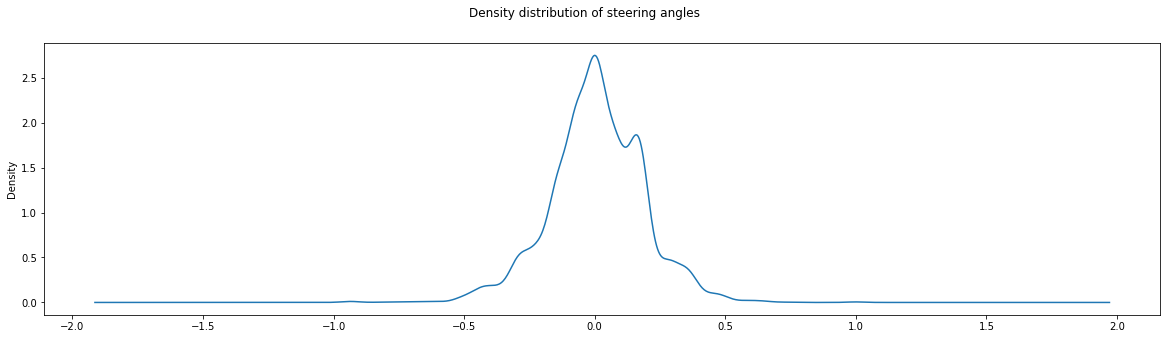

In [5]:
# DF of a 10% sample of our zero deg steering angles
zero_values_to_reappend = df[df["steering"] == 0].sample(int(n_steering_angles_at_zero * 0.10))

# DF of all of our non-zero deg steering angles
all_nonzero_values = df[df["steering"] != 0]

# Create a new dataframe out of the merge of our zero samples and our non-zero data
new_df = all_nonzero_values.merge(zero_values_to_reappend, how='outer')

# Visualize
n_steering_angles_at_zero, n_steering_angles_at_nonzero = get_dataframe_steering_info(new_df)
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Number of datapoints:  12333
Number of datapoints at zero degree steering angle:  436
Percent of steering angle datapoints equal to zero: 3.5%


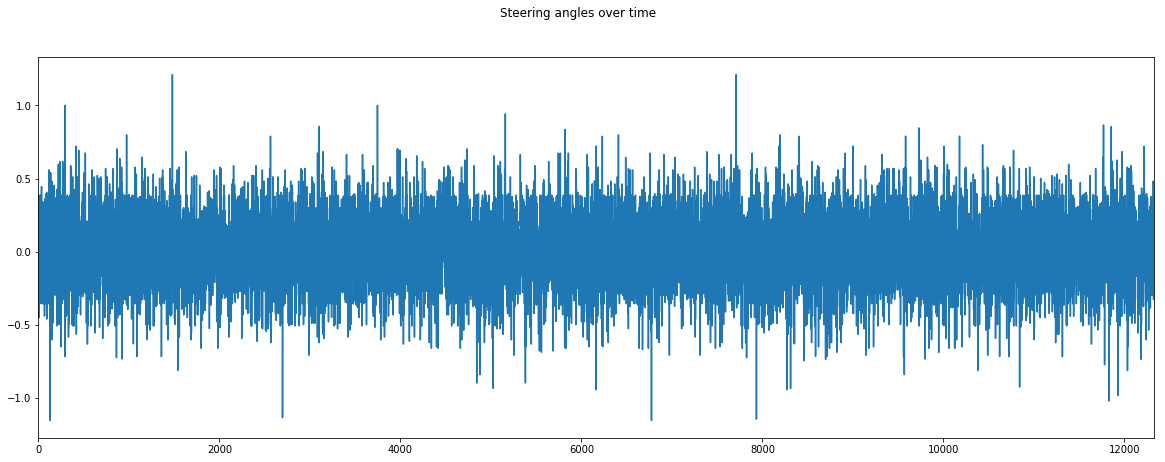

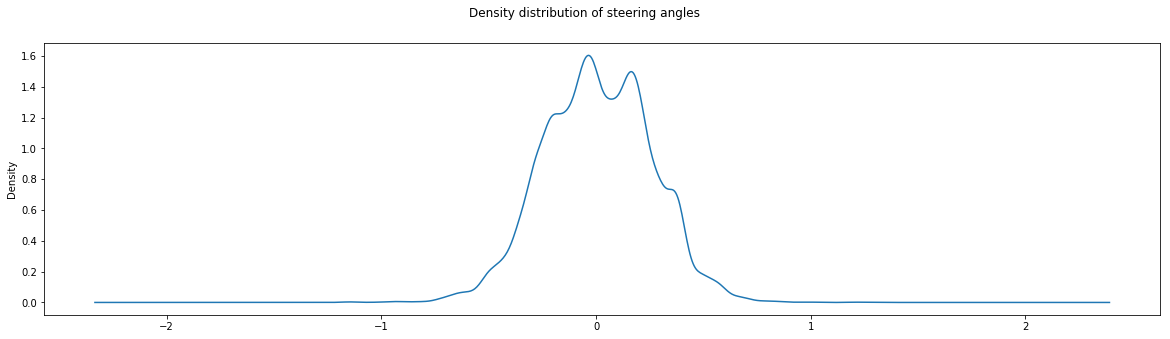

(436, 11897)

In [6]:
# Get our left images and add the steering correction factor
left_images = new_df[["left_img", "steering"]]
left_images.steering += STEER_CORRECTION_FACTOR

center_images = new_df[["center_img", "steering"]]

# Get our left images and subtract the steering correction factor
right_images = new_df[["right_img", "steering"]]
right_images.steering -= STEER_CORRECTION_FACTOR

# concatenate them all and we have ourselves a dataset
dataset = np.concatenate((right_images.values, center_images.values, left_images.values), axis=0)

some_point = dataset[0]

# shuffle the dataset
np.random.shuffle(dataset)

assert (some_point in dataset), "The shuffling should not shuffle the image, steering angle pairing"

dataset_as_df = pd.DataFrame(dataset)

get_dataframe_steering_info(dataset_as_df, steering_col=1)

Angle:  0.0647936


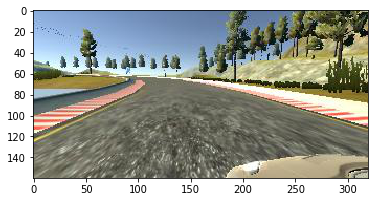

Image shape:  (128, 160, 320, 3)


In [7]:
def df_split_train_test(dataframe, split_frac):
    n_test = int(len(dataframe) * split_frac)
    n_train = len(dataframe) - n_test
    train = dataframe.iloc[:n_train]
    test = dataframe.tail(n_test)
    return (train, test)

def read_img(filepath):
    return cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)

def gen_datapoint(dataframe, batch_size=128):
    while 1:
        datapoints = dataframe.sample(128)
        datapoints[0] = datapoints[0].apply(read_img)
        data = datapoints.as_matrix()
        yield (np.stack(data[:, 0], axis=0), data[:, 1])
        del datapoints

train, validation = df_split_train_test(dataset_as_df, split_frac=VALIDATION_SPLIT)

example_x, example_y = next(gen_datapoint(train))

print("Angle: ", example_y[0])
plt.imshow(example_x[0])
plt.show()

img_shape = example_x.shape
print("Image shape: ", img_shape)


In [8]:
MODEL_NAME = "Nvidia_Drive"

model = Sequential([
        Cropping2D(cropping=((60, 20), (0, 0)), input_shape=img_shape[1:]),
        Lambda(lambda pix: (pix / 255.0) - 0.5),

        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(24, 5, activation="relu"),
        Conv2D(36, 5, activation="relu"),
        
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(48, 5, activation="relu"),
        Conv2D(64, 3, activation="relu"),
        
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(64, 3, activation="relu"),
        
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        
        Dense(100, activation="relu"),
        Dropout(DROPOUT_RATE),
        Dense(50, activation="relu"),
        Dropout(DROPOUT_RATE),
        Dense(10, activation="relu"),
        Dropout(DROPOUT_RATE),
        Dense(1)
    ])
print("\t\t\tModel Summary")
print(model.summary())
MODEL_FILE = "{}-LR{}-EPOCHS{}-DP{}".format(MODEL_NAME, LEARNING_RATE, N_EPOCHS, DROPOUT_RATE)

			Model Summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 80, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 80, 320, 3)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 160, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 156, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 152, 36)       21636     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 76, 36)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 72, 48)        4324

In [9]:
# We define our optimizer with a custom learning rate
optimizer = Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="mse")

In [10]:
model.fit_generator(gen_datapoint(train, BATCH_SIZE),
                    steps_per_epoch=int(len(train)/BATCH_SIZE),
                    epochs=N_EPOCHS,
                    verbose=1,
                    validation_steps=int(len(validation)/BATCH_SIZE),
                    validation_data=gen_datapoint(validation, BATCH_SIZE)
                   )

model.save(MODEL_FILE)

Epoch 1/10
45/45 [==============================] - 8s - loss: 0.0307 - val_loss: 0.0320
Epoch 2/10
45/45 [==============================] - 6s - loss: 0.0256 - val_loss: 0.0250
Epoch 3/10
45/45 [==============================] - 6s - loss: 0.0236 - val_loss: 0.0303
Epoch 4/10
45/45 [==============================] - 6s - loss: 0.0226 - val_loss: 0.0253
Epoch 5/10
45/45 [==============================] - 6s - loss: 0.0222 - val_loss: 0.0213
Epoch 6/10
45/45 [==============================] - 6s - loss: 0.0220 - val_loss: 0.0197
Epoch 7/10
45/45 [==============================] - 6s - loss: 0.0214 - val_loss: 0.0210
Epoch 8/10
45/45 [==============================] - 6s - loss: 0.0214 - val_loss: 0.0206
Epoch 9/10
45/45 [==============================] - 6s - loss: 0.0221 - val_loss: 0.0208
Epoch 10/10
45/45 [==============================] - 6s - loss: 0.0192 - val_loss: 0.0268
